<a href="https://colab.research.google.com/github/waynechu1109/ME-C231A-Final-Project/blob/main/ME_C231A_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies Installation
**Run the code below every time before working on the project.**:

In [ ]:
# # install required dependencies
#import sys
!pip install polytope
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
  #!pip install polytope

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 43.1 MB/s eta 0:00:00
  Created wheel for polytope: filename=polytope-0.2.4-py3-none-any.whl size=47673 sha256=9d8ee7b8cdb090cb90523a1b31e0518a557227732fdf5d4073eb3b2927250a6e
  Stored in directory: /root/.cache/pip/wheels/9b/de/92/9d58cc85957b1657fe6b2e134016350f9311361eaddc4e6d29
Successfully built polytope
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 

### Linearize the function

In [ ]:
import sympy as sp

# Define the variables
z2, z3, u1 = sp.symbols('z2 z3 u1')
Ts = 1
frho = (1-(2.2558*10**-5)*z2)**4.2577
fw = 0.00879*(z2-9000)+51.39
C=1

# Define the function (replace with your actual function)
f = z3+Ts*((u1)-(1/2)*frho*(z3**2 + fw**2)*C)

# Calculate partial derivatives
df_dx = sp.diff(f, z2)
df_dy = sp.diff(f, z3)
df_du = sp.diff(f, u1)

# Specify the operating point
operating_point = {z2: 10000, z3: 268.54, u1:0}

# Evaluate partial derivatives at the operating point
df_dx_op = df_dx.subs(operating_point)
df_dy_op = df_dy.subs(operating_point)
df_du_op = df_du.subs(operating_point)

# Linearize the function
linearized_function = f.subs({z2: operating_point[z2], z3: operating_point[z3], u1: operating_point[u1]}) + df_dx_op * (z2 - operating_point[z2]) + df_dy_op * (z3 - operating_point[z3]) + df_du_op * (u1 - operating_point[u1])

# Print the linearized function
print("Linearized Function:", linearized_function)

Linearized Function: u1 + 1.40334878154089*z2 - 89.4283248881422*z3 - 2501.45199443534


# CFTOC Formulation

Formulation of CFTOC Problem with Pyomo

First we will write a function which formulates and solves a finite time optimal control problem with quadratic cost, linear dynamics, and linear constraints. Then we call this function as a part of the MPC controller. Consider the problem defined below:
\begin{equation}
\begin{aligned}
\min_{x_1 \dots x_N,u_0 \dots u_{N-1}} & \quad x_N^{\top}Px_N+\sum_{k=0}^{N-1}x_k^{\top}Qx_k+u_k^{\top}Ru_k \\
\text{s.t.} & \quad x_{k+1} = Ax_k + Bu_k \quad \forall k=0\dots N-1\\
& \quad x_{min} \leq x_k \leq x_{max}  \quad \forall k=0\dots N-1 \\
& \quad u_{min} \leq u_k \leq u_{max}  \quad \forall k=0\dots N-1 \\
& \quad x_0 = x(0) \\
& \quad x_N \in \mathcal{X}_f
\end{aligned}
\end{equation}

Write a function in the following form which formulates the problem using pyomo and solves the problem using the solver $\texttt{ipopt}$. Test your code on several 1 and 2-state examples.


- $\texttt{feas}$ is a scalar logical indicating the feasibility of the CFTOC problem
- $\texttt{xOpt}$ is a $n_x \times (N+1)$ matrix of the optimal state trajectory, where $n_x$ is the state dimension
- $\texttt{uOpt}$ is a $n_u \times N$ matrix of the optimal input sequence, where $n_u$ is the input dimension
- $\texttt{JOpt}$ is a scalar of the optimal cost from the specified initial condition
- $\texttt{A, B}$ are the state and input matricies of the linear dynamics
- $\texttt{P}$ is the terminal cost matrix
- $\texttt{Q, R}$ are the stage cost matricies
- $\texttt{N}$ is the MPC horizon
- $\texttt{x0}$ is the initial condition
- $\texttt{xL, xU, uL, uU}$ are the box state and input constraints
- $\texttt{bf, Af}$ are used to represent the terminal set. If the terminal set ${\cal X}_f$ is a single point, ${\cal X}_f = \{ \bar{x}_N \}$, the input argument $\texttt{bf}$ is used to specify this single point $\bar{x}_N$, and the input argument $\texttt{Af = []}$ is used to designate this special case of a single-point terminal set. If the terminal set is described by a set of linear inequalities, it can be expressed using the inequality $A_f x_N \leq b_f$.


**If the cell below cannot run properly, "Restart Runtime" then run again.**

In [ ]:
import polytope as pt
import numpy as np
# from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt
# %matplotlib widget

In [ ]:
def solve_cftoc(P, Q, R, N, xref, Af, bf):


    # uref = np.array
    xmax = 50000
    xmin = 0
    hmax = 12000
    hmin = 9000
    vxmax = 268.54
    vxmin = 63.28
    vhmax = 15.24
    vhmin = 10.16
    uxmax = 3.07
    uxmin = 0
    uhmax = 3.07
    uhmin = -3.07
    S = 125.0
    C_d = 0.053
    W = 7e5
    model = pyo.ConcreteModel()
    model.N = N
    rho_0 = 1.225


    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )

    # these are 2d arrays:
    model.Q = Q
    model.P = P
    model.R = R

    # Create state and input variables trajectory:
    # model.x = pyo.Var(model.xIDX, model.tIDX, bounds=(xL,xU))
    model.x = pyo.Var(model.xIDX, model.tIDX)
    # model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))
    model.u = pyo.Var(model.uIDX, model.tIDX)

    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t]-xref[i]) * model.Q[i, j] * (model.x[j, t]-xref[j])
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:
                costTerminal += (model.x[i, model.N]-xref[i]) * model.P[i, j] * (model.x[j, model.N]-xref[j])
        return costX + costU + costTerminal

    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # Constraints:
    # def equality_const_rule(model, i, t):
    #     return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
    #                            +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    # model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    def equality_const_rule1(model, t):
      return model.x[0, t+1] == model.x[0, t] + Ts*model.x[2, t] if t < model.N else pyo.Constraint.Skip
    def equality_const_rule2(model, t):
      return model.x[1, t+1] == model.x[1, t] + Ts*model.x[3, t] if t < model.N else pyo.Constraint.Skip
    def equality_const_rule3(model, t):
      return model.x[2, t+1] == model.x[2, t] + Ts*(model.u[0, t]-0.5*rho_0*(1-2.558e-05*model.x[1, t])**(4.2577)*(model.x[2, t]**2 + (0.00879*(model.x[1, t]-hmin) + 51.39)**2)*S*C_d)/W if t < model.N else pyo.Constraint.Skip
    def equality_const_rule4(model, t):
      return model.x[3, t+1] == model.x[3, t] + Ts*(model.u[1, t]-W*g)/W if t < model.N else pyo.Constraint.Skip
    model.equality_consttraints1 = pyo.Constraint(model.tIDX, rule = equality_const_rule1)
    model.equality_consttraints2 = pyo.Constraint(model.tIDX, rule = equality_const_rule2)
    model.equality_consttraints3 = pyo.Constraint(model.tIDX, rule = equality_const_rule3)
    model.equality_consttraints4 = pyo.Constraint(model.tIDX, rule = equality_const_rule4)

    # Constraints:
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == xref[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == xref[1])
    model.init_const3 = pyo.Constraint(expr = model.x[2, 0] == xref[2])
    model.init_const4 = pyo.Constraint(expr = model.x[3, 0] == xref[3])

    model.constraint5 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[0, t+1] <= xmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint6 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[0, t+1] >= xmin
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint7 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[1, t+1] <= hmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint8 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[1, t+1] >= hmin
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint9 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[2, t+1] <= vxmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint10 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[2, t+1] >= vxmin
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint11 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[3, t+1] <= vhmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint12 = pyo.Constraint(model.xIDX, rule=lambda model, t: model.x[3, t+1] >= vhmin
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint13 = pyo.Constraint(model.uIDX, rule=lambda model, t: model.u[0, t+1] <= uxmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint14 = pyo.Constraint(model.uIDX, rule=lambda model, t: model.u[0, t+1] >= uxmin
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint15 = pyo.Constraint(model.uIDX, rule=lambda model, t: model.u[1, t+1] <= uhmax
                                   if t < N-1 else pyo.Constraint.Skip)

    model.constraint16 = pyo.Constraint(model.uIDX, rule=lambda model, t: model.u[1, t+1] >= uhmin
                                   if t < N-1 else pyo.Constraint.Skip)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False

    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T

    JOpt = model.cost()

    return [model, feas, xOpt, uOpt, JOpt]



# MPC

Consider the following system
\begin{equation}\label{eq:model-int1}
x(k+1)=\begin{bmatrix} 1 &  1\\ 0 & 1 \end{bmatrix}x(k)+
     \begin{bmatrix} 0\\ 1 \end{bmatrix}u(k) \quad \quad (1)   
\end{equation}

The state and input constraints are
\begin{equation}\begin{aligned}
\mathcal{U}: &-0.5\leq u(k)\leq 0.5 \quad \quad \quad \quad \quad \quad \quad \quad (2a)\\
\mathcal{X}: &\begin{bmatrix} -5\\ -5 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 5\\ 5 \end{bmatrix} \quad \quad \quad \quad \quad \quad \quad(2b)
\end{aligned}
\label{eq:con1}\end{equation}

In this problem, we will design an MPC controllers of the form:

\begin{equation*}
   \begin{array}{lll}
       J_0^*(x_0)=  &\displaystyle{\min_{{U_0}}}& \displaystyle{ \color{red}{x_N'Px_N} + \sum_{k=0}^{{N}-1}
  x_k'Qx_k+u_k'Ru_k} \\
       &\text{subject to}   \\
       &&x_{k+1}=Ax_{k}+Bu_{k},\ k=0,\ldots,N-1\\
                       &&x_{k}\in\mathcal{X},~u_{k}\in\mathcal{U},~k=0,\ldots,N-1\\
                       && \color{red}{{x_{N}\in {\mathcal{X}_f} }} \\
                       && x_{0}=x(t)
    \end{array}
\end{equation*}
In this problem, $Q=I_2$, $R=10$, $P=Q$ and $N=3$. Also, we set $\mathcal{X_f}=\mathcal{X}$.

Now solve the MPC problem over a simulation horizon $M=25$ from the initial conditions $x_0 = [-4.5, 2]$.

JOpt= 39.75526315789474
xOpt= [[-4.5     -2.5     -0.90105  0.40737]
 [ 2.       1.59895  1.30842  1.18947]]
uOpt= [[-0.40105263100391203 -0.2905263156548672 -0.11894736838214688 None]]


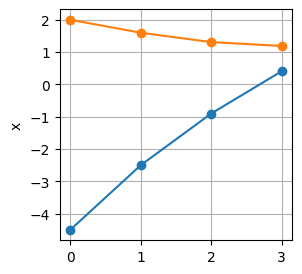

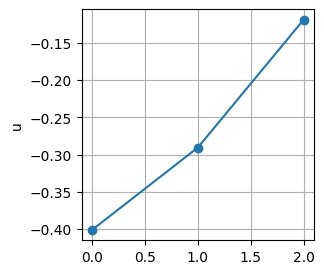

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 11
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.012686014175415039
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [ ]:
# A = np.array([[1, 1],
#                [0, 1]])
# B = np.array([[0],
#               [1]])

w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
P = np.array([[0, 0, 0, 0],
              [0, w5, 0, 0],
              [0, 0, w4, 0],
              [0, 0, 0, w4]])
R = w3*np.eye(2)
Q = np.array([[0, 0, 0, 0],
              [0, w2, 0, 0],
              [0, 0, w1, 0],
              [0, 0, 0, w1]])

Af = np.array([[1, 0, 0, 0],
               [-1, 0, 0, 0],
               []])

bf = np.array([])
# R = 10*np.array([1]).reshape(1,1)
# P = Q
N = 5
# xL = -5
# xU = -xL
# uL = -0.5
# uU = -uL
# reference states
xref = np.array([0, 10000, 268.54, 0]).T    # h = 9000~12000 (m)

[model, feas, xOpt, uOpt, JOpt] = solve_cftoc(P, Q, R, N, xref,Af, bf)

print('JOpt=', JOpt)
print('xOpt=', xOpt)
print('uOpt=', uOpt)
fig = plt.figure(figsize=(3, 3))
plt.plot(xOpt.T, '-o')
plt.ylabel('x')
plt.grid()
fig = plt.figure(figsize=(3, 3))
plt.plot(uOpt.T, '-o')
plt.ylabel('u')
plt.grid()
plt.show()
results = pyo.SolverFactory('ipopt').solve(model).write()

Feasibility = [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


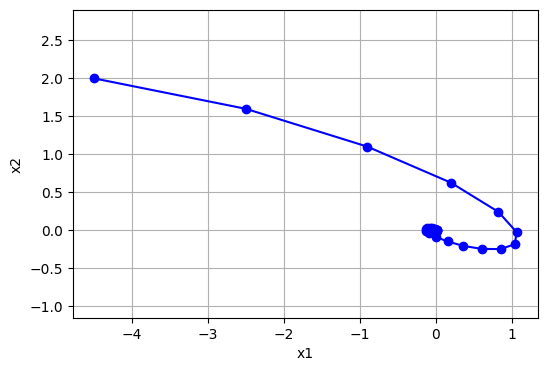

In [ ]:
import numpy as np
import polytope as pt

nx = np.size(A, 0)
nu = np.size(B, 1)

# nx = 2, nu = 1

M = 25   # Simulation time

xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))

feas = np.zeros((M, ), dtype=bool)

fig = plt.figure(figsize=(6, 4))
for t in range(M):
    [model, feas[t], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, t], xL, xU, uL, uU)

    if not feas[t]:
        xOpt = []
        uOpt = []
        break

    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )


print('Feasibility =', feas)

line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.grid()

